
#Implementing MNIST Classifier using NumPy
---
1. loading libraries
2. loading MNIST Dataset
3. Normalize the data
4. Data Augmentation for better accuracy
5.  One-Hot encoding
6. Defining the layers
7. Build the neural network with 2 hidden layers(relu and tanh) and one output layer (softmax)
8. Plotting the testing and training accuracy
9. calculating the accuracy score
10. visualizing the confusion matrix.
11. getting and plotting the common errors of the model

In [18]:
#imposrting the libraries needed
import keras
import pandas as pd
import numpy as np,sys
from keras.datasets import mnist
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

##Loading the MNIST Dataset

In [19]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

##Checking the shape of both test and train dataset

In [20]:
print("Training x_train: ",x_train.shape)
print("Test x_test: ",x_test.shape)

Training x_train:  (60000, 28, 28)
Test x_test:  (10000, 28, 28)


## Subplot to get the x_train digits

(28, 28)


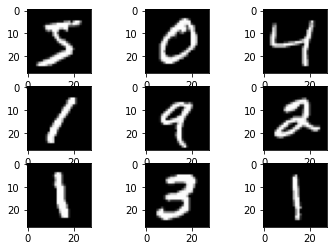

In [21]:
#subplot to get the x_train digits
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
print(x_train[0].shape)

#code to normalize the input data

In [22]:
# reshaping the samples
X_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
X_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
# int to float conversion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

##Image Augmentation done to improve the accuracy

In [23]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train,augment=True)

#once the model is ready we fit the training dataset

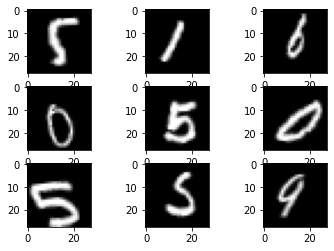

In [24]:
for X_dig_batch, y_dig_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_dig_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

##One Hot Encoding

In [25]:
#getting the encoded labels, we run the one hot encoding only on y_train
images,labels = (X_train.reshape(len(X_train),28*28)/255,y_train)
one_hot_labels = np.zeros((len(labels),10))

In [26]:
for i,l in enumerate(labels):
  one_hot_labels[i][l] = 1
labels = one_hot_labels

In [27]:
test_images = X_test.reshape(len(X_test),28*28)/255
test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
  test_labels[i][l]=1

#Defining the layers and the derivatives

In [28]:
np.random.seed(1)
batch_size = 100
## Defining different activation functions and their derivatives
def tanh(x):
  return np.tanh(x)
def tanh2deriv(output):
  return 1-(output**2)
def relu(x):
  return (x >= 0) * x # returns x if x > 0
def relu2deriv(output):
  return output >= 0 # returns 1 for input > 0
def softmax(x):
  temp = np.exp(x)
  return temp/np.sum(temp,axis=1,keepdims=True)
## Defining Alpha, epochs, 1st hidden layer size, Input Layer size and Output layer size values
alpha,iterations,hidden_size, pixels_per_image, num_labels = (0.01,300,300,784,10)
## Initialize with random weights
weights_01 = np.random.randn(pixels_per_image,hidden_size)*np.sqrt(2.0/hidden_size)
weights_12 = np.random.randn(hidden_size,100)*np.sqrt(2.0/100)
weights_23 = np.random.randn(100,num_labels)*np.sqrt(2.0/num_labels)

##Creating the Neural Network  with proper learning rate and 2 hidden layers and one output layer . Also plotting the test and train accuracy plots

In [30]:

training_log = []
testing_log = []
for j in range(iterations):
  ## errors are initialized to zero
  error,correct_cnt = (0.0,0)
  for i in range(int(len(images)/batch_size)):
    batch_start, batch_end = ((i*batch_size),((i+1)*batch_size))
    layer_0 = images[batch_start:batch_end]
    ## Layer 1 is tanh layer
    layer_1 = tanh(np.dot(layer_0,weights_01))
    ## Adding Dropout for 1st layer
    dropout_mask = np.random.randint(2,size=layer_1.shape)
    layer_1 *= dropout_mask*2 
    ## Layer 2 is relu layer
    layer_2 = relu(np.dot(layer_1,weights_12))
    ## Layer 3 is softmax layer
    layer_3 = softmax(np.dot(layer_2,weights_23))
    error+=np.sum((labels[batch_start:batch_end]-layer_3)**2)
    # for loop to calculate the difference of actual and predicted difference
    for k in range(batch_size):
      correct_cnt+=int(np.argmax(layer_3[k:k+1])==np.argmax(labels[batch_start+k:batch_start+k+1]))
    ## Calculating the layer 3 delta
    layer_3_delta = (labels[batch_start:batch_end]-layer_3)/(batch_size * layer_3.shape[0])
    ## Calculating the layer 2 delta using the relu2derivative created above
    layer_2_delta = layer_3_delta.dot(weights_23.T)*relu2deriv(layer_2)
    ## Calculating the layer 2 delta using the tanh2derivative created above
    layer_1_delta = layer_2_delta.dot(weights_12.T)*tanh2deriv(layer_1)
    layer_1_delta *= dropout_mask

    weights_23 += alpha*layer_2.T.dot(layer_3_delta)
    weights_12 += 0.1*layer_1.T.dot(layer_2_delta)
    weights_01 += 0.2*alpha*layer_0.T.dot(layer_1_delta)
  test_correct_cnt=0
  y_pred=[]
  actual_labels=[]
  ### creating the structure for test data
  for i in range(len(test_images)):
    layer_0 = test_images[i:i+1]
    layer_1 = tanh(np.dot(layer_0,weights_01))
    layer_2 = relu(np.dot(layer_1,weights_12))
    layer_3 = np.dot(layer_2,weights_23)
    y_pred += [int(np.argmax(layer_3))]
    actual_labels += [np.argmax(test_labels[i:i+1])]
    test_correct_cnt += int(np.argmax(layer_3)==np.argmax(test_labels[i:i+1]))
  ## printing out the test and train accuracy
  if (j%10==0):
   # sys.stdout.write("\n"+"I:"+str(j)+" Test-Acc:"+str(test_correct_cnt/float(len(test_images)))+" Train-Acc:"+'{:0.6f}'.format(correct_cnt/float(len(images))))
    #Plotting the test and train accuracy
    rounded_training_log=round(correct_cnt/float(len(images)),3)
    training_log.append(rounded_training_log)
    rounded_testing_log=round((test_correct_cnt/float(len(test_images))),3)
    testing_log.append(rounded_testing_log) 
    #print("I:"+str(j))
    #print("Training accuracy:",rounded_training_log)
    #print("Testing accuracy:",rounded_testing_log)
    sys.stdout.write("\n"+"I:"+str(j)+" Test-Acc:"+str(test_correct_cnt/float(len(test_images)))+" Train-Acc:"+'{:0.6f}'.format(correct_cnt/float(len(images))))
#plt.plot(training_log,label='training accuracy')
#plt.plot(testing_log,label='testing accuracy')
#plt.legend(loc='best')
#plt.grid()
#plt.show()


I:0 Test-Acc:0.8781 Train-Acc:0.795600
I:10 Test-Acc:0.8801 Train-Acc:0.797517
I:20 Test-Acc:0.8811 Train-Acc:0.799100
I:30 Test-Acc:0.8817 Train-Acc:0.801000
I:40 Test-Acc:0.8822 Train-Acc:0.801950
I:50 Test-Acc:0.8821 Train-Acc:0.801467
I:60 Test-Acc:0.8839 Train-Acc:0.803950
I:70 Test-Acc:0.8847 Train-Acc:0.803950
I:80 Test-Acc:0.8864 Train-Acc:0.805650
I:90 Test-Acc:0.8884 Train-Acc:0.804383
I:100 Test-Acc:0.8884 Train-Acc:0.803150
I:110 Test-Acc:0.8886 Train-Acc:0.808683
I:120 Test-Acc:0.8892 Train-Acc:0.806950
I:130 Test-Acc:0.8906 Train-Acc:0.807483
I:140 Test-Acc:0.8901 Train-Acc:0.807967
I:150 Test-Acc:0.891 Train-Acc:0.810083
I:160 Test-Acc:0.8916 Train-Acc:0.810233
I:170 Test-Acc:0.8919 Train-Acc:0.811733
I:180 Test-Acc:0.8929 Train-Acc:0.808533
I:190 Test-Acc:0.8937 Train-Acc:0.809783
I:200 Test-Acc:0.8937 Train-Acc:0.810817
I:210 Test-Acc:0.8944 Train-Acc:0.810733
I:220 Test-Acc:0.8946 Train-Acc:0.812867
I:230 Test-Acc:0.8953 Train-Acc:0.811150
I:240 Test-Acc:0.8957 Train

In [31]:
print(training_log)
print(testing_log)

[0.796, 0.798, 0.799, 0.801, 0.802, 0.801, 0.804, 0.804, 0.806, 0.804, 0.803, 0.809, 0.807, 0.807, 0.808, 0.81, 0.81, 0.812, 0.809, 0.81, 0.811, 0.811, 0.813, 0.811, 0.814, 0.816, 0.813, 0.817, 0.817, 0.816]
[0.878, 0.88, 0.881, 0.882, 0.882, 0.882, 0.884, 0.885, 0.886, 0.888, 0.888, 0.889, 0.889, 0.891, 0.89, 0.891, 0.892, 0.892, 0.893, 0.894, 0.894, 0.894, 0.895, 0.895, 0.896, 0.896, 0.897, 0.898, 0.898, 0.897]


#Calculating the accuracy score

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
acc_score=accuracy_score(actual_labels, y_pred)*100
acc_score

89.88000000000001

# Visualization-Confusion Matrix

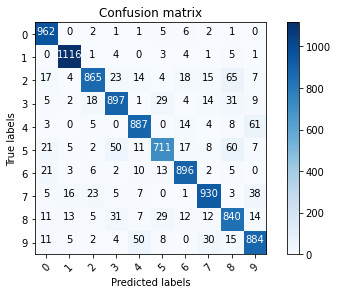

In [33]:
# Confusion matrix plotting for the actual and y_pred values
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')

# plotting the confusion matrix for the actual labels nd y_pred
confusion_mtrx = confusion_matrix(actual_labels, y_pred) 
# confusion matrix
plot_confusion_matrix(confusion_mtrx, classes = range(10))

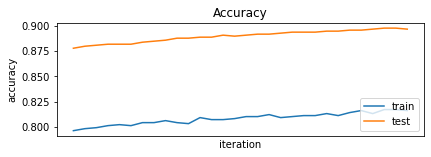

In [34]:
# plotting the metrics
plt.subplot(2,1,1)
plt.plot(training_log)
plt.plot(testing_log)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.xticks([])
plt.legend(['train', 'test'], loc='lower right')


plt.tight_layout()

# Common errors of ypred from actual labels

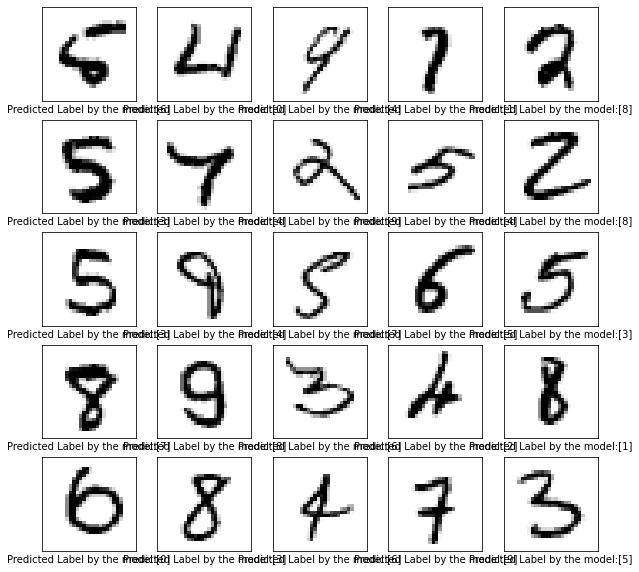

In [35]:
#common errors of ypred from actual labels
err_index = []
for i in range(0, len(y_pred)):
  if(y_pred[i] != actual_labels[i]):
    #appending the erroneous labels index
    err_index.append(i)
# plotting the predicted from actual digit images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[err_index[i]].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel("Predicted Label by the model:" + str([y_pred[err_index[i]]]))
plt.show()